# Stage1 t-SNE Comparison

Load the stage1 VQ-VAE checkpoint, extract pre-quant (z_top, z_bot) and post-quant (q_top, q_bot) feature maps for a stratified subset of a single machine type, run t-SNE, and compare clustering before vs after quantization. Also plot code usage histograms for coarse (top) and fine (bottom) resolutions.

## 1. Setup

Paths, imports, and config. `N_SAMPLES` (e.g. 800) balances t-SNE runtime and cluster visibility; perplexity 30 is a reasonable default for N≈800.

In [18]:
import sys
from pathlib import Path
from collections import defaultdict
import random

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Subset

_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

CKPT_DIR = PROJECT_ROOT / "checkpoints"
DATA_PATH = "../../data/dcase2020-task2-dev-dataset"  # set to your DCASE root
MACHINE_TYPE = "fan"
STAGE1_CKPT = PROJECT_ROOT / "checkpoints" / "stage1/ToyCar+ToyConveyor+fan+pump+slider+valve/stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt"  # or stage1_{machine_type}_iter_*.pt

N_SAMPLES = 800   # 500–1000 recommended for t-SNE; stratified by machine_id
BATCH_SIZE = 64
TSNE_PERPLEXITY = 30
TSNE_RANDOM_STATE = 42
RANDOM_SEED = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}, N_SAMPLES={N_SAMPLES}")
print(f"STAGE1_CKPT: {STAGE1_CKPT}")

Device: cuda, N_SAMPLES=800
STAGE1_CKPT: /home/ac-4090/Documents/docs/semcom-sDSR/checkpoints/stage1/ToyCar+ToyConveyor+fan+pump+slider+valve/stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt


## 2. Load dataset and stratified subset

Group indices by `machine_id`, then sample proportionally up to `N_SAMPLES` so each appliance instance is represented.

In [19]:
from src.data.dataset import DCASE2020Task2LogMelDataset

dataset = DCASE2020Task2LogMelDataset(
    root=DATA_PATH,
    machine_type=MACHINE_TYPE,
    normalize=True,
)

_, _, n_mels, T = dataset.data.shape
print(f"Dataset: {len(dataset)} samples, n_mels={n_mels}, T={T}, machine_ids={dataset.machine_ids}")

def stratified_sample_indices(dataset, n_samples: int, seed: int = 42):
    by_id = defaultdict(list)
    for i in range(len(dataset)):
        by_id[dataset._machine_id_strs[i]].append(i)
    rng = random.Random(seed)
    target_per_id = max(1, n_samples // len(by_id))
    indices = []
    for mid, idx_list in sorted(by_id.items()):
        k = min(len(idx_list), target_per_id)
        indices.extend(rng.sample(idx_list, k))
    if len(indices) > n_samples:
        indices = rng.sample(indices, n_samples)
    elif len(indices) < n_samples:
        short = n_samples - len(indices)
        extra = []
        for mid, idx_list in sorted(by_id.items()):
            remaining = [i for i in idx_list if i not in indices]
            extra.extend(rng.sample(remaining, min(short, len(remaining))))
            if len(extra) >= short:
                break
        indices.extend(extra[:short])
    return indices

subset_indices = stratified_sample_indices(dataset, N_SAMPLES, seed=RANDOM_SEED)
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Subset: {len(subset_indices)} indices")

Padded T: 313 → 320 (target: 320)
DCASE2020Task2LogMelDataset: fan | 3675 spectrograms, shape (3675, 1, 128, 320) | IDs: ['id_00', 'id_02', 'id_04', 'id_06'] | 0.60 GB in RAM
Dataset: 3675 samples, n_mels=128, T=320, machine_ids=['id_00', 'id_02', 'id_04', 'id_06']
Subset: 800 indices


## 3. Load stage1 model

Build VQ-VAE with same hyperparameters as `scripts/train.py` and load checkpoint.

In [20]:
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer

def build_vq_vae(n_mels: int, T: int) -> VQ_VAE_2Layer:
    return VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(1024, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )

vq_vae = build_vq_vae(n_mels, T)
if STAGE1_CKPT.exists():
    ckpt = torch.load(STAGE1_CKPT, map_location="cpu", weights_only=False)
    vq_vae.load_state_dict(ckpt["model_state_dict"])
    print(f"Loaded checkpoint: {STAGE1_CKPT}")
else:
    print("Warning: Stage1 checkpoint not found; using random weights.")
vq_vae = vq_vae.to(DEVICE)
vq_vae.eval()

Loaded checkpoint: /home/ac-4090/Documents/docs/semcom-sDSR/checkpoints/stage1/ToyCar+ToyConveyor+fan+pump+slider+valve/stage1_ToyCar+ToyConveyor+fan+pump+slider+valve_final.pt


VQ_VAE_2Layer(
  (_encoder_bot): EncoderBot(
    (_conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU()
            (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_encoder_top): EncoderTop(
    (_conv1): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
           

## 4. Extract features

Run batches through `encode_with_prequant`, global average pool (B, C, H, W) → (B, C), and collect z_top, z_bot, q_top, q_bot plus machine_id for each sample.

In [21]:
def pool_spatial(x: torch.Tensor) -> torch.Tensor:
    """(B, C, H, W) -> (B, C)"""
    return x.mean(dim=(2, 3))

list_z_top, list_z_bot, list_q_top, list_q_bot = [], [], [], []
list_machine_ids = []

with torch.no_grad():
    for batch in loader:
        if isinstance(batch, (list, tuple)):
            x = batch[0]
            mid_batch = batch[2]  # machine_id per sample
        else:
            x = batch
            mid_batch = ["unknown"] * x.shape[0]
        x = x.to(DEVICE)
        q_bot, q_top, z_bot, z_top = vq_vae.encode_with_prequant(x)
        list_z_top.append(pool_spatial(z_top).cpu())
        list_z_bot.append(pool_spatial(z_bot).cpu())
        list_q_top.append(pool_spatial(q_top).cpu())
        list_q_bot.append(pool_spatial(q_bot).cpu())
        list_machine_ids.extend(mid_batch)

Z_top = torch.cat(list_z_top, dim=0).numpy()
Z_bot = torch.cat(list_z_bot, dim=0).numpy()
Q_top = torch.cat(list_q_top, dim=0).numpy()
Q_bot = torch.cat(list_q_bot, dim=0).numpy()
machine_ids_subset = list_machine_ids

N = Z_top.shape[0]
print(f"Features: Z_top {Z_top.shape}, Z_bot {Z_bot.shape}, Q_top {Q_top.shape}, Q_bot {Q_bot.shape}, N={N}")

Features: Z_top (800, 128), Z_bot (800, 128), Q_top (800, 128), Q_bot (800, 128), N=800


## 5. Code usage histograms (top and bottom resolutions)

For each sample we have quantized maps q_top (coarse) and q_bot (fine). We infer the code index at each spatial position by nearest codebook lookup, then aggregate counts across the subset and plot which codes are used most.

In [22]:
def get_code_usage_counts(vq_vae, loader, device):
    """Return (counts_top, counts_bot) as 1D arrays of length num_embeddings_top/bot."""
    emb_top = vq_vae._vq_top._embedding.weight  # (num_emb_top, dim)
    emb_bot = vq_vae._vq_bot._embedding.weight  # (num_emb_bot, dim)
    num_top = emb_top.shape[0]
    num_bot = emb_bot.shape[0]
    counts_top = np.zeros(num_top, dtype=np.int64)
    counts_bot = np.zeros(num_bot, dtype=np.int64)
    emb_top_np = emb_top.detach().cpu().numpy()
    emb_bot_np = emb_bot.detach().cpu().numpy()

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            x = x.to(device)
            q_bot, q_top, _, _ = vq_vae.encode_with_prequant(x)
            # q_top (B, C, H, W) -> (B*H*W, C)
            flat_top = q_top.permute(0, 2, 3, 1).reshape(-1, q_top.shape[1]).cpu().numpy()
            flat_bot = q_bot.permute(0, 2, 3, 1).reshape(-1, q_bot.shape[1]).cpu().numpy()
            # Nearest codebook index: argmin of squared distances
            # (N, C) @ (C, K) -> (N, K); dist^2 = ||a||^2 + ||b||^2 - 2 a.b
            d_top = flat_top.dot(emb_top_np.T)
            d_top = -2 * d_top + (emb_top_np ** 2).sum(axis=1)
            idx_top = np.argmin(d_top, axis=1)
            d_bot = flat_bot.dot(emb_bot_np.T)
            d_bot = -2 * d_bot + (emb_bot_np ** 2).sum(axis=1)
            idx_bot = np.argmin(d_bot, axis=1)
            for i in idx_top:
                counts_top[i] += 1
            for i in idx_bot:
                counts_bot[i] += 1
    return counts_top, counts_bot

counts_top, counts_bot = get_code_usage_counts(vq_vae, loader, DEVICE)
print(f"Top (coarse) codes: {counts_top.shape[0]} total, {np.sum(counts_top > 0)} used")
print(f"Bottom (fine) codes: {counts_bot.shape[0]} total, {np.sum(counts_bot > 0)} used")

Top (coarse) codes: 1024 total, 1024 used
Bottom (fine) codes: 4096 total, 4094 used


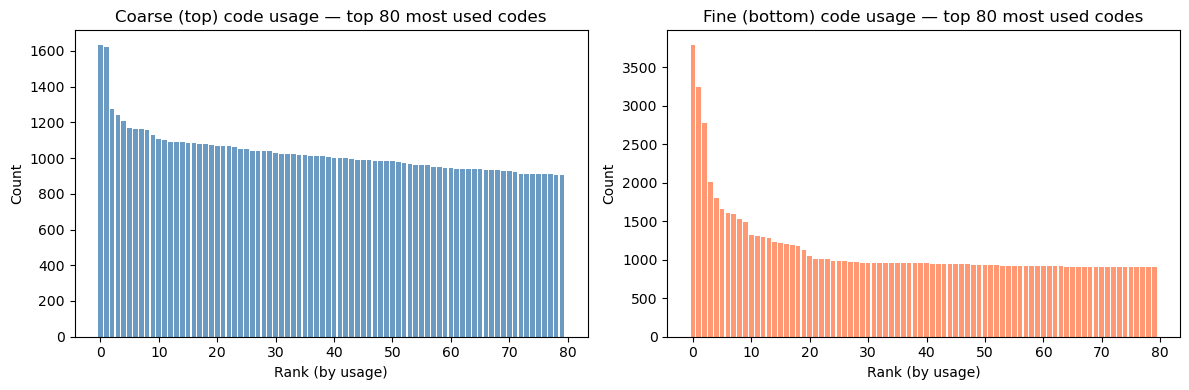

In [23]:
def plot_code_usage_histograms(counts_top, counts_bot, top_k=80):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # Sort by count descending and take top_k
    order_top = np.argsort(counts_top)[::-1]
    order_bot = np.argsort(counts_bot)[::-1]
    x_top = np.arange(min(top_k, len(counts_top)))
    axes[0].bar(x_top, counts_top[order_top[:top_k]], color="steelblue", alpha=0.8)
    axes[0].set_title(f"Coarse (top) code usage — top {top_k} most used codes")
    axes[0].set_xlabel("Rank (by usage)")
    axes[0].set_ylabel("Count")

    x_bot = np.arange(min(top_k, len(counts_bot)))
    axes[1].bar(x_bot, counts_bot[order_bot[:top_k]], color="coral", alpha=0.8)
    axes[1].set_title(f"Fine (bottom) code usage — top {top_k} most used codes")
    axes[1].set_xlabel("Rank (by usage)")
    axes[1].set_ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_code_usage_histograms(counts_top, counts_bot, top_k=80)

## 6. t-SNE

Run t-SNE on each of the four representations (z_top, z_bot, q_top, q_bot) to get 2D embeddings.

In [24]:
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, random_state=TSNE_RANDOM_STATE)

emb_z_top = tsne.fit_transform(Z_top)
emb_z_bot = tsne.fit_transform(Z_bot)
emb_q_top = tsne.fit_transform(Q_top)
emb_q_bot = tsne.fit_transform(Q_bot)

print("t-SNE done for all four representations.")

t-SNE done for all four representations.


## 7. Plot 2×2 t-SNE panels

Scatter plots colored by `machine_id` for pre-quant coarse/fine and post-quant coarse/fine.

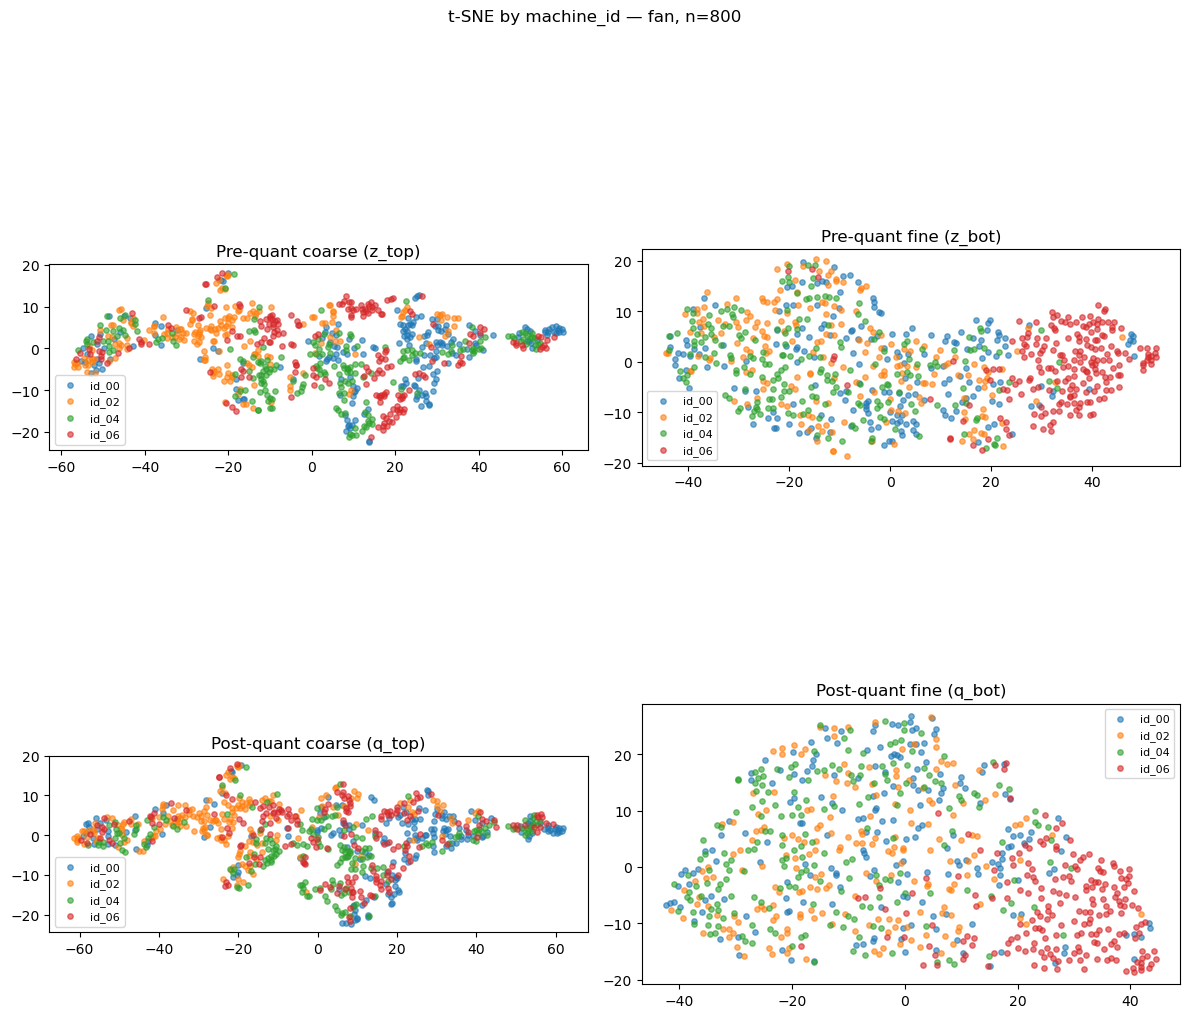

In [26]:
unique_ids = sorted(set(machine_ids_subset))
cmap = plt.cm.tab10
colors = {mid: cmap(i % 10) for i, mid in enumerate(unique_ids)}
color_vec = [colors[mid] for mid in machine_ids_subset]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

panels = [
    (emb_z_top, "Pre-quant coarse (z_top)"),
    (emb_z_bot, "Pre-quant fine (z_bot)"),
    (emb_q_top, "Post-quant coarse (q_top)"),
    (emb_q_bot, "Post-quant fine (q_bot)"),
]
for ax, (emb, title) in zip(axes.flat, panels):
    for mid in unique_ids:
        mask = [m == mid for m in machine_ids_subset]
        ax.scatter(emb[mask, 0], emb[mask, 1], c=[colors[mid]], label=mid, alpha=0.6, s=15)
    ax.set_title(title)
    ax.legend(loc="best", fontsize=8)
    ax.set_aspect("equal")

plt.suptitle(f"t-SNE by machine_id — {MACHINE_TYPE}, n={N}", fontsize=12)
plt.tight_layout()
plt.show()